In [1]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
#from install import *
#install_requirements(is_chapter7_v2=True)

fatal: destination path 'notebooks' already exists and is not an empty directory.
/content/notebooks


In [2]:
!pip install transformers==4.39.3 #normally 4.41.2
!pip install datasets==2.20.0

!pip install pyarrow==16.0
!pip install requests==2.32.3

!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0

!pip install importlib-metadata

!pip install accelerate -U


# file specific
!pip install farm-haystack[colab]==1.26.2
!pip install farm-haystack[elasticsearch]==1.26.2
!pip install farm-haystack[inference]==1.26.2
!pip install farm-haystack[metrics]==1.26.2
!pip install farm-haystack[elasticsearch]==1.26.2
!pip install -U scikit-learn==1.5.1
!pip install matplotlib==3.9.0


"""
# file specific // depracated version
!pip install farm-haystack[colab]==1.17.2
!pip install farm-haystack[elasticsearch]==1.17.2
!pip install farm-haystack[inference]==1.17.2
!pip install farm-haystack[metrics]==1.17.2
!pip install farm-haystack[elasticsearch]==1.17.2
!pip install -U scikit-learn==1.3.2 # 1.5.1 latest version
!pip install matplotlib==3.9.0
"""

  Using cached elastic_transport-7.16.0-py2.py3-none-any.whl (35 kB)
  Using cached elasticsearch-7.17.9-py2.py3-none-any.whl (385 kB)
  Using cached urllib3-1.26.19-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'\n# file specific // depracated version\n!pip install farm-haystack[colab]==1.17.2\n!pip install farm-haystack[elasticsearch]==1.17.2\n!pip install farm-haystack[inference]==1.17.2\n!pip install farm-haystack[metrics]==1.17.2\n!pip install farm-haystack[elasticsearch]==1.17.2\n!pip install -U scikit-learn==1.3.2 # 1.5.1 latest version\n!pip install matplotlib==3.9.0\n'

In [3]:
from utils import *
setup_chapter()

Using transformers v4.39.3
Using datasets v2.20.0


In [4]:
#%%capture
# Verifying packages installed are now up to date
!pip show pyarrow requests transformers datasets torch torchaudio importlib-metadata

Name: pyarrow
Version: 15.0.2
Summary: Python library for Apache Arrow
Home-page: https://arrow.apache.org/
Author: 
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy
Required-by: bigframes, cudf-cu12, datasets, db-dtypes, ibis-framework, mlflow, pandas-gbq, tensorflow-datasets
---
Name: requests
Version: 2.32.3
Summary: Python HTTP for Humans.
Home-page: https://requests.readthedocs.io
Author: Kenneth Reitz
Author-email: me@kennethreitz.org
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: certifi, charset-normalizer, idna, urllib3
Required-by: bigframes, CacheControl, community, datasets, docker, earthengine-api, farm-haystack, fastai, folium, gcsfs, gdown, geocoder, google-api-core, google-cloud-bigquery, google-cloud-storage, google-colab, huggingface-hub, kaggle, kagglehub, mlflow, moviepy, music21, pandas-datareader, panel, pooch, posthog, prompthub-py, pymystem3, requests-cache, req

In [5]:
!nvidia-smi

Thu Jul  4 13:58:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

In [7]:
# file specific, open src
#from haystack.telemetry import tutorial_running

#tutorial_running(7)

In [8]:
import torch
import transformers
import datasets
import tokenizers

print("PyTorch Version:" + torch.__version__)
print("Transformers Version:" + transformers.__version__)
print("Datasets Version:" + datasets.__version__)
print("Tokenizers Version:" + tokenizers.__version__)

PyTorch Version:2.3.0+cu121
Transformers Version:4.39.3
Datasets Version:2.20.0
Tokenizers Version:0.15.2


In [9]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [10]:
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# Question Answering

## Building a Review-Based QA System

The Dataset

In [11]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa", trust_remote_code=True)
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [12]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

In [13]:
print(subjqa["train"]["answers"][1])
# for output key, i think 1302 simply mean its token

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


#### Notes

1. **answers.answer_start**: This field indicates the character-level start index where each answer span begins in the text of the review. If there are multiple answers to a question, each index corresponds to where each answer starts in the text. It allows the system or user to locate exactly where in the review text the answer is found.

2. **answers.answer_subj_level**: This field describes the subjectivity level of the answer on a scale from 1 to 5, with 1 being the most subjective. This metric assesses how much personal opinion or judgment is included in the text of the answer, as opposed to objective facts.

3. **answers.ans_subj_score**: This is a numerical score calculated (possibly using the TextBlob package or another sentiment analysis tool) that quantifies the subjectivity of the answer text. Higher scores typically indicate higher subjectivity, but the exact scale and interpretation can depend on the methodology used for scoring.

4. **answers.is_ans_subjective**: This boolean field is derived from the `answer_subj_level`. It indicates whether the answer is considered subjective, typically based on a threshold (e.g., scores below 4 are considered as subjective). This provides a quick binary classification of whether the answer contains subjective elements or not.

2. **Converting Dataset Splits to pandas DataFrames**:
   ```python
   dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
   ```
   - `subjqa.flatten().items()`: This likely refers to a method that retrieves data from a dataset, potentially in a nested structure, and `flatten()` might be used to transform it into a more manageable format. `.items()` then iterates over this flattened data, providing key-value pairs.
   - `dset.to_pandas()`: Converts each dataset (or portion of a dataset, referred to as `dset`) into a pandas DataFrame. This is common when dealing with structured data that needs to be analyzed or manipulated.
   - `{split: dset.to_pandas() for split, dset in ...}`: This is a dictionary comprehension that creates a dictionary (`dfs`) where each key is a dataset split name (`split`) and the value is the corresponding DataFrame.

3. **Looping through DataFrames**:
   ```python
   for split, df in dfs.items():
       print(f"Number of questions in {split}: {df['id'].nunique()}")
   ```
   - `dfs.items()`: Iterates over the dictionary `dfs`, which contains split names and their corresponding DataFrames.
   - `df['id'].nunique()`: For each DataFrame (`df`), it counts the number of unique values in the 'id' column, which presumably corresponds to unique questions.
   - `print(f"Number of questions in {split}: {df['id'].nunique()}")`: Prints out the number of unique questions for each split of the dataset.

The code snippet you've provided is a Python script using pandas, a data manipulation and analysis library. Here's what each part of the code is doing:

1. **Defining Columns**:
   ```python
   qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
   ```
   This line creates a list named `qa_cols` containing the names of specific columns that will be used from the dataset. These columns include the title of the item/business discussed, the question, the text of the answers, the starting position of each answer in the context, and the context itself which is typically the text of the review.

2. **Sampling Data**:
   ```python
   sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
   ```
   - `dfs['train']`: This accesses the 'train' portion of a dataset that might be stored in a dictionary-like object (`dfs`) where the keys represent different splits (e.g., training, validation).
   - `[qa_cols]`: This indexes the dataframe to only include the columns specified in the `qa_cols` list.
   - `.sample(2, random_state=7)`: This method randomly selects 2 rows from the dataframe. The `random_state=7` parameter ensures that the random selection is reproducible; the same rows will be sampled every time the code is run, which is useful for debugging or examples.

3. **Output (`sample_df`)**:
   - The output displayed shows the sampled data. For instance, row with index `791` shows a product with the ID `B005DKZTMG`, and the question "Does the keyboard lightweight?". The answer given is "this keyboard is compact", with no indication of the starting position shown in the snippet.

This code is typically used for exploring or inspecting a dataset by viewing a small random sample of the data, which can help in understanding the structure and content without loading the entire dataset into memory or displaying it all at once.

#### Back to Code

In [14]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()} # .flatten() flatten a nested array for example to 1-dimensional, for ease of exploration

for split, df in dfs.items(): # .items() splits and iterates over K V pairs in dictionary
    print(f"Number of questions in {split}: {df['id'].nunique()}") # .nunique() counts number of unique values in 'id' column

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [15]:
qa_cols = ["title",                     # id of buisness discussed
           "question",                  # The question (written based on a query opinion)
           "answers.text",
           "answers.answer_start",
           "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7) # [qa_cols] ensures only specified columns are included
                                                            # .sample(2, random_state=7) randomly selects 2 rows from df, random_state is seed i believe
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [16]:
start_idx = sample_df["answers.answer_start"].iloc[0][0] # refer to iloc notes below
                                                         # this line of code is using value in 'answer_start' column to retrieve where the answer's character stars in 'context'
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0]) # calculates length of answer text
sample_df["context"].iloc[0][start_idx:end_idx] # this then slices the 'context' column, which retrieves answer.text based on calculated index
                                                # i believe this code block is to demonstrate where the answer is, and the usefulness of the columns etc.

'this keyboard is compact'

## Notes

The `iloc` method in pandas is used to access rows and columns in a DataFrame by integer-location based indexing. This method allows you to retrieve data by specifying the numerical position of the data you want.

### Understanding `iloc`

- **`iloc[row_index]`**: This will retrieve the row at the position specified by `row_index`. Remember, indices start at 0 in pandas, much like Python lists.
- **`iloc[row_index, column_index]`**: This will retrieve the element at the specified row and column positions. You can specify both the row and the column by their integer indices.

### Example of `iloc`

Let's say we have a DataFrame `df`:

|   | A    | B    | C    |
|---|------|------|------|
| 0 | data1| data2| data3|
| 1 | data4| data5| data6|
| 2 | data7| data8| data9|

- `df.iloc[0]` will retrieve the first row: `A: data1, B: data2, C: data3`.
- `df.iloc[1, 2]` will retrieve the element in the second row, third column, which is `data6`.

### What `iloc[0][0]` Does

In the context of pandas:
- `iloc[0]` first accesses the first row of the DataFrame.
- Appending `[0]` to this will access the first element of the series returned by `iloc[0]`.

Thus, `iloc[0][0]` effectively retrieves the first element of the first row of the DataFrame. This is a more "chained" way of accessing data which can be less efficient and less clear than using `iloc[0, 0]`, which directly retrieves the first element of the first row in one operation.

For instance, using the DataFrame `df` from above:
- `df.iloc[0][0]` or `df.iloc[0, 0]` will both retrieve `data1`.

Using `iloc[0, 0]` is generally preferable as it is clearer and potentially more efficient, particularly for larger DataFrames.

## Back to Code

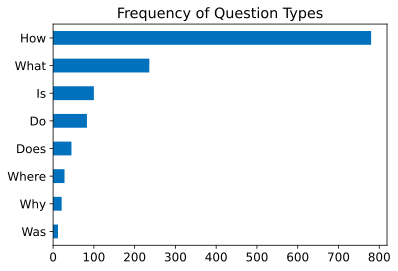

In [17]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"] # this code block is used to get a feel of what the dataset contains.
                                                                            # These values in the question_types array consist of the different type of common
                                                                            # question starters in the dataset. Hence, we will look at their respective freqeuncies in the dataset as seen below.

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True] # .value_counts count the ocurrences of each unique value, which .startswith() outputs true or false
                                                                                # we want the number of 'True', hence [True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [18]:
print(dfs["train"].title)

0       B00001P4ZH
1       B00001P4ZH
2       B00001P4ZH
3       B00001WRSJ
4       B00001WRSJ
           ...
1290    B00H3OYSHW
1291    B00H3OYSHW
1292    B00HNGB1YS
1293    B00HPM1G8Q
1294    B00HPM1G8Q
Name: title, Length: 1295, dtype: object


In [19]:
%%capture
# uncapture for future reference
for question_type in ["How", "What", "Is"]: # we can see How, What, Is are the most common ones. Now taking a peek at what does these questions look like.
    """fun fact, for nested dictionaries dict[XX].YY is the same as dict[XX][YY]!!"""
    print(dfs["train"].question.str.startswith(question_type))
    print(dfs["train"]['question'][dfs["train"].question.str.startswith(question_type)])
          # solved it
                # when you apply "dfs["train"].question.str.startswith(question_type)"
                      # this basically outputs True or False throughout the whole dataframe
                      # this is apparently known as BOOLEAN MASKING/INDEXING
                # when you then apply BOOLEAN MASKING onto a dictionary, the only ones with true will hence remain
    for question in (dfs["train"]['question'][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)):
        print(question)
    for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
        print(question)


## Extracting Answers from Text

Tokenizing text for QA

In [20]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [22]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

# we are alrdy familliar with the "input_ids" and "attention_mask" below.
# "token_type_ids" basically indicate the type of the word, i.e. question==0 and context==1

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [23]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [24]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [25]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [26]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


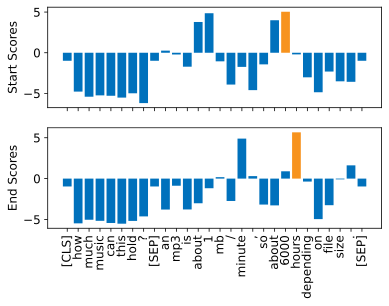

In [27]:
#caption Predicted logits for the start and end tokens—the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

#### Notes for graph

The line `plt.xticks(token_ids, tokens, rotation="vertical")` in the code snippet you shared is used to set the x-axis tick labels on a matplotlib plot. Let's break down what each part of this function does:

1. **`token_ids`**: This argument sets the positions along the x-axis where the tick marks (and corresponding labels) should be placed. In this context, `token_ids` is likely a range of integers that correspond to the indices of the tokens.

2. **`tokens`**: This argument provides the labels that should be displayed at each tick mark on the x-axis. Here, `tokens` would be a list of words or tokens that have been extracted from the input text that the model is processing.

3. **`rotation="vertical"`**: This argument controls the orientation of the tick labels. Setting it to `"vertical"` causes the labels to be drawn perpendicular to the axis, which is useful for improving readability when there are many labels or when the labels are long strings.

This function call is particularly useful in visualizations where you need to label individual data points along the x-axis, which is common in NLP tasks to show which tokens are being evaluated or highlighted, as seen in your example of visualizing the logits for start and end positions in a question answering model. By rotating the labels vertically, the plot can accommodate more labels without them overlapping or becoming unreadable.

The line `token_ids = range(len(tokens))` in your code creates a sequence of integers from 0 up to (but not including) the length of the `tokens` list. Here's how it works:

- `tokens` is a list of tokenized words or elements extracted from a text.
- `len(tokens)` calculates the number of elements in the `tokens` list.
- `range(len(tokens))` generates a range object that yields integers starting from 0 up to `len(tokens) - 1`.

This sequence of integers, `token_ids`, typically serves as indices for each token in the `tokens` list. In visualizations or operations where you need to reference the position of each token, `token_ids` provides a convenient way to do so. For example, when plotting, these indices can be used to align each token with corresponding values on a chart, ensuring that each token is correctly positioned along the x-axis.

#### Back to code

In [28]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [29]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651614844799042, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082969546318054,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253532975912094,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [30]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

Notes

In Hugging Face's Transformers library, when using question-answering models, the `handle_impossible_answer` parameter is specifically designed to enable the model to determine when no suitable answer can be found within the provided context. By default, this parameter is not set to `True`, meaning the model will always attempt to provide an answer from the context, even if it's not a good fit.

Setting `handle_impossible_answer=True` allows the model to return an empty answer if it evaluates that there truly isn't a suitable response available in the context. This is particularly useful in scenarios where it's important to know whether a reliable answer exists within the provided text, rather than forcing an answer that may not be accurate.

The `ax=ax` parameter in the plotting function, specifically in the line `dfs["train"]["n_tokens"].hist(bins=100, grid=False, color="C0", ax=ax)`, serves an important role in controlling where the plot is rendered. Here's how it functions:

- **`ax`**: This represents an Axes object in matplotlib, which is essentially a part of the figure where the drawing of the plot occurs. An Axes object can include elements like labels, lines, the plot itself, and other graphical elements.

- **`ax=ax` in the Function**: When you specify `ax=ax` in the histogram function, you're directing matplotlib to render this particular histogram on the previously defined Axes object (`ax`). This allows you to control exactly where on the figure the histogram appears. Without specifying `ax`, the histogram would be drawn on the current active Axes or create a new one if none is active, which might not be desirable if you're working with subplots or have specific layout requirements.

This approach is particularly useful when creating complex figures that contain multiple subplots. By defining and passing specific Axes objects, you can ensure that each plot element appears in the intended position within the figure.

Dealing with long passages

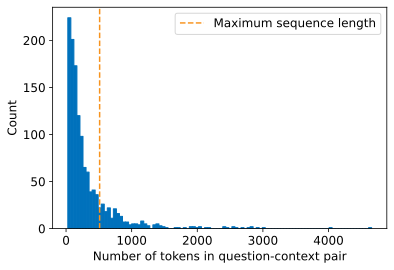

In [31]:
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"]) # calculate length of token_ids

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1) # axis=1 indicates row-wise operation // .apply() applies the defined function on dict

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax) # bins=1000 means 1000 different histogram bars // grid=False turns off grid lines //
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", label="Maximum sequence length") # adds a vertical dashed line at x=512 // represents maximum input size of MiniLM
plt.legend()
plt.ylabel("Count")
plt.show()

In [32]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"],
                              example["context"],
                              return_overflowing_tokens=True,
                              max_length=100,
                              stride=25)

In [33]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [34]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and do not feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears
even after listening to music with them on all day. the sound is night and day
better than any ear - bud could be and are almost as good as the pro 4aa. they
are " open air " headphones so you cannot match the bass to the sealed types,
but it comes close. for $ 32, you cannot go wrong. [SEP]



# Using Haystack to Build a QA Pipeline

## Elasticsearch Notes

### Elasticsearch

**Elasticsearch** is a powerful open-source search and analytics engine that enables you to store, search, and analyze big volumes of data quickly and in near real-time. It is generally used as the underlying engine/technology that powers applications that have complex search features and requirements. Here are some of its key features:

- **Distributed by nature:** Elasticsearch automatically distributes data and query load across all available hardware.
- **Full-text search:** It's highly optimized for text-centric operations but also supports handling other types of data.
- **Scalability:** It is designed to scale out on horizontal hardware, making it capable of handling petabytes of data.
- **Real-time operations:** Elasticsearch operations are real-time, in the sense that after a document is indexed, it is searchable in near real-time.
- **Restful API:** Elasticsearch supports a very user-friendly REST API for accessing its features.

### Haystack

**Haystack** is an open-source NLP framework for building search systems that work with large collections of texts. It allows you to set up pipelines to retrieve information from documents through different retrieval techniques. Here’s a rundown of its components and capabilities:

- **Document Stores:** Haystack can connect to different types of document stores, which store and manage the documents used in your search. Elasticsearch is one of the supported document stores.
- **Retrievers:** They are responsible for fetching a subset of documents that are most likely to contain the answer to a query. Haystack supports several retrieval methods, including the traditional BM25 and more advanced neural network approaches.
- **Readers:** They take the documents retrieved by the Retrievers and extract the precise answer to the query. This is often a Transformer-based model.
- **Pipelines:** Haystack allows you to build complex search pipelines that chain together retrievers and readers to handle the entire process of document retrieval and question answering.

### Integration of Elasticsearch with Haystack

From the script you shared, it's clear that you're setting up an Elasticsearch instance as a document store for Haystack. You start by downloading and setting up Elasticsearch, then integrating it with Haystack by creating an `ElasticsearchDocumentStore`. This document store serves as the backend where your documents are stored, indexed, and queried during the retrieval process.

You also utilize various Haystack components like the `BM25Retriever` for retrieving documents based on the BM25 ranking function, and the `FARMReader` (from the deepset's FARM framework) to extract answers from the text. Finally, you set up an `ExtractiveQAPipeline` that combines the retriever and reader to process queries and extract answers.

This setup is typical for applications requiring sophisticated text searching capabilities, where simple keyword searches are not sufficient and understanding the context of the query is necessary.

Elasticsearch is indeed free and open-source, released under the Apache 2.0 license, which allows users to use, modify, and distribute the software freely. However, it's important to note that while the core features of Elasticsearch are free, Elastic—the company behind Elasticsearch—also offers commercial products and services based on this technology. These commercial offerings often include additional features like security enhancements, monitoring, and management tools which are part of the Elastic Stack (formerly known as the ELK Stack, which includes Elasticsearch, Logstash, and Kibana).

### Why Offer Free Software?
1. **Community Building and Contribution:** By making Elasticsearch open-source, Elastic has built a large community of developers and users who contribute to the software, help with debugging, and develop new features. This community-driven development accelerates improvement and innovation.

2. **Widespread Adoption:** Offering a core product for free encourages widespread adoption. As more companies and developers use Elasticsearch, they are more likely to purchase premium services and support for large-scale deployments.

3. **Ecosystem Development:** A broad user base for Elasticsearch encourages the development of an ecosystem of plugins and integrations, which in turn enhances the core product's capabilities and appeal.

### How Does Elasticsearch Power Searches Cost-Effectively?
Elasticsearch is designed to be highly efficient in how it handles data and executes searches, making it capable of performing fast searches across large volumes of data. Here are a few key elements:

- **Inverted Index:** This is the fundamental data structure used by Elasticsearch to achieve fast full-text searches. An inverted index lists every unique word that appears in any document and identifies all the documents each word occurs in.

- **Distributed Nature:** Elasticsearch can run on multiple servers which divides the data and distributes the load across different nodes. This not only increases fault tolerance but also enhances the processing power available for queries.

- **Caching and Tuning:** Various caching mechanisms ensure that frequent queries are served rapidly. Additionally, Elasticsearch allows for significant tuning to optimize both indexing and search performance based on specific use cases.

### Cost Considerations
While Elasticsearch itself might be free, deploying and managing it at scale can involve costs:
- **Hardware:** Running Elasticsearch requires servers. For large datasets or high query volumes, you might need powerful hardware or many servers.
- **Cloud Hosting:** If you use a cloud service to host Elasticsearch, you'll need to pay for the cloud resources.
- **Maintenance and Management:** Large deployments may require dedicated teams for maintenance and tuning.
- **Premium Features:** Elastic offers a subscription service called Elastic Cloud which includes managed Elasticsearch along with additional features and support.

In summary, while the core of Elasticsearch is free, operating it at scale or utilizing advanced features can involve additional costs. The free, open-source model is a business strategy that has proven successful for many companies, allowing them to benefit from widespread use while monetizing premium features and services.

Let's break down what each code block in the screenshot is doing:

### First Code Block
This block is responsible for downloading, extracting, and setting up Elasticsearch on your machine:
1. **Downloading Elasticsearch**: It uses `wget` with the `-nc` flag to avoid re-downloading the file if it already exists, and `-q` to keep the operation quiet (less verbose).
2. **Extracting the downloaded file**: It extracts the tar.gz file containing Elasticsearch using `tar -xzf`, which specifies decompression and extraction of the tarball.

### Second Code Block
This block sets up and starts Elasticsearch as a background process:
1. **Setting permissions**: `chown -R daemon:daemon elasticsearch-7.9.2` changes the ownership of the Elasticsearch directory, making the user `daemon` the owner, which is typical for processes that don't need superuser privileges.
2. **Starting Elasticsearch**:
   - `Popen` from the `subprocess` module is used to execute the Elasticsearch executable. This starts Elasticsearch as a separate process.
   - `stdout=PIPE` and `stderr=STDOUT` redirect the output and errors so they can be handled or ignored by your Python script.
   - `preexec_fn=lambda: os.setuid(1)` sets the user ID of the process to 1 (daemon) right before the child is executed.
3. **Sleep**: The script pauses for 30 seconds (`sleep 30`) to give Elasticsearch enough time to start up before the script continues.

### Third Code Block
This block provides an alternative method to launch Elasticsearch if Docker is installed:
- **Using Haystack's utility function**: `launch_es()` is a convenience function provided by the Haystack library that attempts to start an Elasticsearch container using Docker. This simplifies the setup by managing Docker commands internally.

### Fourth Code Block
This block checks the status of the Elasticsearch server:
- **Curl command**: The `curl` command is used to make a GET request to `localhost:9200/?pretty`. This URL is the default endpoint for Elasticsearch's REST API, and the `?pretty` query parameter asks Elasticsearch to return the output in a more readable JSON format.
- The output of this command would display the current status and some information about the Elasticsearch instance, such as its version, cluster name, and other configuration details.

Each block is structured to ensure that Elasticsearch is downloaded, configured, and initiated properly, with alternative setups considered, and finally, verifying the setup by querying the Elasticsearch server. This setup is typical in a development environment where Elasticsearch is a dependency for applications requiring search capabilities.

## Back to Coding

Initialising a document store

In [89]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [90]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [91]:
# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

In [92]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "ba7417b27efa",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "NblNR2LDT5uB7DyIwR7_Ag",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [93]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True) # return_embedding=True means this document store will also handle embedding vectors for
                                                                   # documents // These embeddings will later used for semantic search task, particularly when
                                                                   # using dense retrievers that compare embedding vectors to find relevant documents.

                                                                   # embedding here refers to textual data converted to high-dimensional vector representation

In [94]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0: # checking for existing documents or labels
    document_store.delete_documents(index="document")
    document_store.delete_documents(index="label")

Since version 1.0 of Haystack, Documents now have a field `content`, which replaces the field `text`. This change was introduced because Documents have become more flexible and can also store tables in addition to texts.

In [95]:
from itertools import islice

print(dfs["train"].columns)
print(list(islice(dfs["train"]["review_id"].items(), 7)))
#print(list(islice(dfs["train"]["context"].items(), 7)))

Index(['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id',
       'question_subj_level', 'ques_subj_score', 'is_ques_subjective',
       'review_id', 'id', 'title', 'context', 'question', 'answers.text',
       'answers.answer_start', 'answers.answer_subj_level',
       'answers.ans_subj_score', 'answers.is_ans_subjective', 'n_tokens'],
      dtype='object')
[(0, '882b1e2745a4779c8f17b3d4406b91c7'), (1,
'ce76793f036494eabe07b33a9a67288a'), (2, 'd040f2713caa2aff0ce95affb40e12c2'),
(3, '043e7162df91f6ea916c790c8a6f6b22'), (4,
'29ccd7e690050e2951be49289e915382'), (5, 'deb36e2a474c0eb4b67356d8c423435b'),
(6, '456b1ca6c68d516da88d50f7b5451d39')]


In [96]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], # actual text of document // the review itself
             "id": row["review_id"],            # id of review
             "meta":{"item_id": row["title"],   # id of buisness
                     "question_id": row["id"],  # id of the question
                     "split": split}}           # split, whether its training, validation or test set
            for _,row in df.drop_duplicates(subset="context").iterrows()] # loop which processes different splits of dataset (training, validation, test sets)
    document_store.write_documents(documents=docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


Initialising a retriever

In Haystack 1.4 `ElasticsearchRetriever` was renamed to `BM25Retriever`. You can still use `ElasticsearchRetriever` for compatibility reasons in version 1.5 but it might be removed in future releases.

In [97]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [98]:
item_id = "B0074BW614"
query = "Is it good for reading?" # sets up initial conditions for retrieval, i.e. --> item ID and user's query

retrieved_docs = bm25_retriever.retrieve(query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})
                            # top_k specifies how many docunments to return

In [99]:
retrieved_docs[0]

# can see the score computed by ElasticSearch, larger score means a better match.

<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '4a6aa9c7808ebba8d35aeecbcc3c30fe'}>

Initialising a reader

In [100]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2" #alternative larger models: deepset/roberta-base-squad2-distilled or deepset/xlm-roberta-large-squad2 or the tiny distilled model: deepset/tinyroberta-squad2
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt,  # afaik, FARMReader is a type of reader which specialises on utilising transformers // other types can be used with HayStack library too
                    progress_bar=False,
                    max_seq_len=max_seq_length, # for input, or documents retrieved i believe
                    doc_stride=doc_stride,
                    return_no_answer=True) # output no answer when determined no satisfactory answer to question is present in provided text

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [101]:
print(question)
print(context) # defined in previous codeblocks
print(reader.predict_on_texts(question=question, texts=[context], top_k=1)) # inputs question (query) and context (input documents) // top_k shows top 1st answer from QA pipeline

How much music can this hold?
An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.
{'query': 'How much music can this hold?', 'no_ans_gap': 12.648088693618774,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293056964874268, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids':
['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


Putting it all together

In [102]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever) # combines retriever and reader to form complete QA system.
                                                                     # using ExtractiveQAPipeline because we are interested in extracting answers.

## Notes

The format of parameters that can be passed to a pipeline has slightly changed. In the old version, the method call was
```python
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})
```
Now, you can specify the name of the node, e.g., `"Retriever"`, that you want to pass parameters to.

### Understanding the FARMReader

The **FARMReader** in the Haystack library is a type of "reader" module specifically designed for the task of question answering (QA). It uses models from the Hugging Face's Transformers library, which are based on the transformer architecture.

#### What is a Reader?
In the context of question answering systems:
- A **reader** is a component that interprets and processes the contents of texts to extract precise answers to questions. It's a more advanced form of information retrieval that goes beyond just fetching relevant documents (a task typically handled by a "retriever") and focuses on understanding and extracting the exact answers from the fetched documents.

#### What is a Transformer?
- A **transformer** is a type of deep learning model that has been highly successful in a wide range of natural language processing tasks. It relies on mechanisms called attention and self-attention, which allow the model to weigh the importance of different words in a sentence, regardless of their position. This ability to manage long-range dependencies in text is what makes transformers particularly effective for language tasks.

### Capabilities of the FARMReader
- **Model Flexibility**: It can utilize any transformer-based model that has been pretrained on a QA task, available from Hugging Face's model hub. These models include variants of BERT, RoBERTA, DistilBERT, etc., which are adapted to extract answers from a given text.
- **Context Handling**: It can handle long documents effectively by splitting them into manageable chunks. The `max_seq_len` parameter determines how long each chunk can be, and `doc_stride` controls how much overlap there is between consecutive chunks. This ensures that no potential answers are lost due to the chunking of text.
- **Adaptive Answering**: With `return_no_answer` set to true, the FARMReader is capable of determining when a satisfactory answer to a question is not present in the provided texts, which is crucial for maintaining the reliability of answers in professional or critical use cases.

### How It Works in a QA Pipeline
1. **Document Retrieval**: Initially, documents relevant to a query are retrieved by a retriever component.
2. **Answer Extraction**: The reader then processes these documents. It comprehensively understands the context, interprets the query, and extracts the section of the text that answers the query.
3. **Returning Results**: The reader returns the extracted answers along with confidence scores, which indicate how likely it is that the answer is correct based on the model's assessment.

In summary, the FARMReader in Haystack leverages advanced transformer-based models to perform deep semantic analysis and extraction of answers, making it an essential component for sophisticated QA systems that require not just retrieval but precise understanding and response generation based on the content of documents.

In question-answering systems, the term "reader" can refer to various models and approaches used to extract answers from text. While the FARMReader focuses on using transformer-based models due to their effectiveness in understanding complex language patterns, there are other types of readers that have been employed in QA systems, each with their own strengths and methodologies. Below are a few common types of readers apart from those that utilize transformers:

### 1. Rule-Based Readers
- **Description**: These readers operate based on a set of predefined rules and heuristics. They scan texts for patterns that match these rules to identify possible answers.
- **Use Case**: They are often used in domain-specific applications where the types of questions and answers are relatively predictable and can be effectively captured through rules.

### 2. Pattern Matching Readers
- **Description**: These utilize regular expressions or other pattern-matching techniques to find text that fits certain templates or formats, which indicate answers.
- **Use Case**: Useful in scenarios where answers follow a specific format, such as extracting dates, prices, or other structured data from unstructured text.

### 3. Machine Learning-Based Readers (Non-Transformer)
- **Description**: These include a variety of machine learning models that aren’t based on the transformer architecture, such as Random Forests, Support Vector Machines, or even earlier neural network architectures like LSTMs and GRUs.
- **Use Case**: These models might be used for simpler or more constrained QA tasks, where the overhead of a large transformer model is unnecessary.

### 4. Retrieval-Based Readers
- **Description**: Instead of understanding and processing the content, these readers focus on retrieving segments of text that are likely to contain the answer. They rank these segments based on relevance to the question.
- **Use Case**: Effective when the answer needs to be extracted from large databases or document sets where direct answer extraction is computationally impractical.

### 5. Ensemble Readers
- **Description**: These combine multiple reading strategies, often incorporating both machine learning models and rule-based components, to improve accuracy and robustness.
- **Use Case**: Used in complex systems where a single model's approach may not be sufficient, especially in heterogeneous or noisy environments.

### Are these in FARMReader?
The FARMReader specifically utilizes models from the Hugging Face's Transformers library, which primarily focuses on the latest advancements in neural network-based natural language processing, particularly those involving the transformer architecture. Therefore, the types of readers like rule-based or retrieval-based are not part of FARMReader itself. However, the broader Haystack library, which includes FARMReader, supports integrating various types of readers and retrievers to create a flexible and powerful search system. This means while FARMReader focuses on transformer models, other parts of the Haystack ecosystem can accommodate different reader types depending on the specific needs of the application.

This diversity in reader types allows developers and researchers to tailor their QA systems to the specific requirements of their tasks, balancing between computational efficiency, accuracy, and the complexity of the language involved.

## Back to Coding

In [103]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split":["train"]}},
                                      "Reader": {"top_k": n_answers}}) # each pipeline has their own respective 'run()' method which specifies how query flow should be executed.
                                                                       # For ExtractiveQAPipeline we need to pass the query, the number of documents, top_k_retrievers (top documents to retrieve),
                                                                       # top_k_reader (top answers to extract with reader)
                                                                       # in out case, need to specify a filter over "item_id" which is done using "filters" argument. // item_id == title of subjqa dataset,
                                                                                                                                                                                    # or the title of buisnesses

print(f"Question: {preds['query']} \n") # prints "query" that's passed in. This input is also in the dictionary when .run() is used

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...") # context seems to be surrounding of where answer was retrieved from
    print("\n\n")

Question: Is it good for reading?

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great
for reading books when no light is available. Amazing sound but I suggest good
headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



Answer 3:
Review snippet: ...None...





# Improving our QA Pipeline

Evaluating the retriever is the same as evaluating a `DocumentSearchPipeline`, which consists only of a single node, a retriever.

In [104]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

Since version 1.0 of Haystack, `Answer` has become a class and each `Label` contains a `Document` that the `Label` refers to. Thus, the initialization of a `Label` in the following code cell has changed.
Note that the code printed in the book had a small bug. In the for loop of the old code, `Label`s were created that were all initialized with the same id. Thus they were handled as duplicates and not all of them were stored in the document store when we later on called `document_store.write_labels(labels, index="label")`:
```python
for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
```


In [105]:
# creating and preparing labels for training/evaluating a QA pipeline using Haystack.
from haystack import Label, Answer, Document

print(dfs["test"].columns)

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):                    # this checks if question has any answer, e.g. if no answer, len() will output 0
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"],
                answer=Answer(answer=answer),  # answer text wrapped in Answer object
                origin="gold-label",           # indicating this label comes from "gold" data, meaning its a known correct answer
                document=Document(content=row["context"], id=row["review_id"]), # Document from which the answer should be retrievable. Wrapped in a "Document" object.
                meta=meta,                     # metadata
                is_correct_answer=True,        # indicates this is correct answer
                is_correct_document=True,      # indicates that this is the correct document from which answer should be derived
                no_answer=False,               # indicates that there's an answer, not a situation where no answer is possible from given text
                filters={"item_id": [meta["item_id"]], "split":["test"]}) # additional filters that can be used during retrieval for more refined searching or during evaluation
            labels.append(label)
    # Populate labels for questions without answers
    else:                                           # what happens if len() = 0. Or no answer.
        label = Label(
            query=row["question"],
            answer=Answer(answer=""),
            origin="gold-label",
            document=Document(content=row["context"], id=row["review_id"]),
            meta=meta,
            is_correct_answer=True,
            is_correct_document=True,
            no_answer=True,
            filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

Index(['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id',
       'question_subj_level', 'ques_subj_score', 'is_ques_subjective',
       'review_id', 'id', 'title', 'context', 'question', 'answers.text',
       'answers.answer_start', 'answers.answer_subj_level',
       'answers.ans_subj_score', 'answers.is_ans_subjective'],
      dtype='object')


In [106]:
print(labels[0])

<Label: {'id': 'a455371f-0bfb-41ae-9604-b47e0be77123', 'query': 'What is the
tonal balance of these headphones?', 'document': {'id':
'f011c75fb8d26066217e64b3ff470d84', 'content': "I have been a headphone fanatic
for thirty years and have owned and used a variety of headphones over those
years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6
excells as the best value of any headphone that I've ever owned.  They are
especially good at producing natural-sounding deep bass, and the overall
octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the 

In [107]:
# writing labels to Elasticsearch now that we have our labels in a list.
document_store.write_labels(labels, index="label") # index= specifies index in document store where labels are stored

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 455 question-answer pairs


## Notes on Query regarding Label document_store process

Your questions touch on several key aspects of setting up and managing a machine learning pipeline for question answering (QA). Let’s address each of your concerns:

### Why Focus on the Test Split?

In typical machine learning workflows, especially in supervised learning, datasets are divided into three splits:
1. **Training Set**: Used to train the model, teaching it how to recognize patterns and make predictions.
2. **Validation Set**: Used to fine-tune model parameters and prevent overfitting. It helps in selecting the best model configuration that generalizes well on unseen data.
3. **Test Set**: Used to evaluate the performance of the model after it has been trained and tuned. This set is crucial because it acts as new, unseen data, providing insights into how the model is expected to perform in the real world.

The focus on the test split for evaluation in your case is because the setup shown is likely aimed at evaluating the performance of the retriever component within a QA pipeline, not training it. The primary purpose here is to measure how well the retriever works after it (and possibly other components) has already been developed or trained.

### What About Training?

In the context of the code and workflow you described, it appears that training isn't the focus—evaluation is. In a typical QA system using tools like Haystack:
- **Training** would involve not only setting up labels but also actively using these labels to train a model, often a reader in the case of deep learning-based QA systems. The retriever might also be trained if it uses a machine learning model rather than a rule-based approach like BM25.
- However, **retrievers** like BM25 are based on traditional information retrieval techniques that don’t require training in the conventional sense. They use algorithms based on document frequency and term frequency to rank documents.

### Why Wrap Everything in Objects and Store in a DataStore?

- **Structure and Standardization**: Wrapping data into objects (like `Document`, `Answer`, and `Label` in Haystack) standardizes how data is handled, making the system more modular and scalable. It helps in ensuring that each component of the system can interact seamlessly with others.
- **Functionality**: Using a datastore (like Elasticsearch) allows efficient storage, retrieval, and search operations on large datasets. It supports complex querying capabilities, which are essential for both training and evaluation phases in a QA system.

### Why Re-aggregate Labels?

- **Efficiency**: Initially, labels are stored in the datastore to keep a persistent, structured record of all interactions and annotations. Aggregating these labels later on allows for flexible manipulation of this data, enabling specific subsets to be formed based on current evaluation needs without permanent alterations to the underlying data.
- **Evaluation Needs**: Sometimes, different evaluations require viewing the data in different aggregations or groupings to answer specific questions about model performance or to conduct error analysis.

### Conclusion

In summary, focusing solely on the test split for specific evaluations is common when the goal is to assess a system's readiness or performance post-development. The use of structured objects and a datastore helps in managing data effectively in complex systems like QA pipelines, where multiple components (retrievers, readers) need to access shared data efficiently. If the goal shifts towards model improvement or addressing specific issues, similar setups can be applied to training and validation datasets to ensure comprehensive development and tuning.

Absolutely, you can use the training and validation sets for evaluation purposes as well, and there are several scenarios where this might be necessary or beneficial:

### 1. **Model Development and Tuning**
During the development of a machine learning model, especially in a complex domain like question answering, it's crucial to monitor how the model performs not just on unseen data (test set), but also on the data it was trained on (training set) and data used for tuning (validation set):

- **Training Set Evaluation**: This helps in understanding the learning progress of the model. If the model performs poorly on the training set, it might be underfitting, which means the model is too simple to learn the underlying pattern. Evaluating on the training set can help diagnose this issue.
  
- **Validation Set Evaluation**: Regularly evaluating the model on the validation set during the training process allows for monitoring overfitting and underfitting. Unlike the test set, the validation set can be used to make decisions about model adjustments, hyperparameter tuning, and more without compromising the integrity of the test set as a truly independent evaluation.

### 2. **Hyperparameter Tuning**
Evaluating different configurations of the model using the validation set helps in selecting the best version of the model. For instance, adjusting the retriever’s parameters, or the reader’s processing capabilities, and checking their impact on the validation set can guide decisions that balance between underfitting and overfitting.

### 3. **Feature Engineering**
By evaluating how different features perform on the training and validation sets, developers can iteratively improve feature engineering. This process involves adding new features, modifying existing features, or removing redundant features based on their performance impact observed through evaluation on these sets.

### 4. **Cross-Validation**
In some scenarios, especially when the available data is limited, it might be useful to use cross-validation techniques. This involves rotating which subsets of the data are considered as training, validation, and test sets. This ensures that every data point is used for both training and validation (and sometimes testing), maximizing the use of available data.

### 5. **Consistency Checks**
Evaluating the model on training and validation sets can also serve as a consistency check, ensuring that the model behaves as expected across different subsets of the data. It helps in identifying if the model is too tailored to specific quirks of the training data (overfitting).

### Wrapping Up
In practice, while test data is crucial for final model validation, using training and validation data for ongoing evaluation during the development cycle is essential for iteratively improving model performance. The key is to ensure that each type of data is used appropriately to both develop and validate the model effectively, without leaking test data insights into the model development process, which could lead to biased or overly optimistic performance estimates.

Aggregation in the context of machine learning, especially within systems like Haystack that handle question-answering (QA), is an essential process for organizing and managing data more efficiently. The purpose is to streamline the evaluation or training process by grouping related data in a way that enhances performance analysis, training effectiveness, or system validation.

### Why Aggregation is Important:

#### 1. **Reducing Redundancy**:
Aggregation helps in condensing data by merging related records based on certain criteria, such as a common question ID or document ID. This is particularly useful in QA systems where multiple instances of questions might exist across different parts of a dataset. By aggregating these instances, you ensure that during evaluation or training, each unique question is treated as a single entity, reflecting a more realistic scenario and preventing skewed results due to repeated question instances.

#### 2. **Enhancing Data Management**:
In a large dataset, managing individual labels can become cumbersome and inefficient. Aggregation simplifies this by grouping related labels, making data handling more manageable and the data itself more interpretable. For example, if several users provide answers to the same question in a QA system, aggregating these answers allows you to handle this collective information as a single unit, simplifying processes like label updates, deletions, or detailed analyses.

#### 3. **Improving Model Training and Evaluation**:
- **Training**: During model training, particularly with complex models like those used in QA, having aggregated labels means that the model can learn from a consolidated view of what constitutes a correct answer for a given question. This can lead to better generalization when the model encounters similar questions.
- **Evaluation**: For evaluation, aggregation allows the model to be tested across a broader base of answers or scenarios for the same question, providing a deeper insight into the model’s capabilities and weaknesses. It enables performance metrics to be calculated more accurately, considering all relevant instances and variations.

#### 4. **Facilitating Advanced Analytical Tasks**:
Aggregation can enable more sophisticated analytics, such as calculating statistics on groups of data, analyzing trends across different segments, or even performing complex data transformations that are necessary for certain types of machine learning models.

### Why Not Just Use the Original Labels?

Using the original, non-aggregated labels might seem simpler, but it can introduce several challenges:
- **Inefficiency in Handling Large Volumes**: Non-aggregated data can be redundant and voluminous, making it less efficient to process, especially when the dataset grows large.
- **Potential for Data Skew**: If the labels are not aggregated, the model might be overly influenced by repeated instances of the same question-answer pair, skewing its learning and evaluation processes.
- **Complications in Performance Measurement**: Evaluating a model’s performance can become complicated if the same questions are treated as separate instances. Aggregation ensures that each unique question contributes once to the performance metrics, giving a clearer picture of the model's true accuracy.

### Conclusion

In summary, aggregation is a crucial step in preparing data for effective training and evaluation in a QA system. It makes the dataset more manageable, ensures the integrity of the evaluation process, and helps in achieving better generalization and performance from the model. While using non-aggregated data might be tempting for simplicity, the long-term benefits of aggregation in handling complexity and improving outcomes are significant.

## Back to Code

In [108]:
# this block retrieves and aggregates all labels from document store.
      # These labels represent question-answer pairs needed for evaluation.

labels_agg = document_store.get_all_labels_aggregated( # aggregates all question-answer pairs assosciated with unique ID. This method returns a list of MultiLabel objects.
    index="label",                        # index= specifies index in document store where labels are stored
    open_domain=True,                     # indicates that labels should be aggregated without restricting to a specific domain or subset of data, making aggregation comprehensive.
    aggregate_by_meta=["item_id"]         # tells system to aggregate labels based on "item_id" meta data field
)                                                 # this is useful when questions are about specific items, and you want to consolidate data related to each item

print(len(labels_agg)) # labels_agg seems to be a new subset created from document_store. Which is then passed in laterwards seems like.
print(document_store.get_label_count(index="label"))

330
455


Since version 1.0 of Haystack, the evaluation of pipelines is much different compared to the version described in the first edition of the book. `Pipeline` now has a method `eval()`, which runs the pipeline given input data from labels and returns the prediction and the labels in the format of one Pandas dataframe per pipeline node. This result is stored in `eval_result` in the following code cell. On these results, we can calculate arbitrary metrics - without rerunning the computationally intesive inference steps of the pipeline.

In [109]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(      #"""notice how .eval() is a method of pipe <-- which has desired model inputted"""
    labels=labels_agg,                    # feeds aggregated labels into evaluation function
    params={"Retriever": {"top_k": 3}},   # sets retriever to return the top 3 documents for each query during evaluation. Makes method calculates how often true answer
)                                               # appears within top 3 results returned by the retriever

"""top_k parameter here. The higher it is the better, for improved recalls. However it slows down the pipeline. To guide our decision on what value to pick, we will
   create a function which loops over several k-values and compare its respective performance metric"""

metrics = eval_result.calculate_metrics() # calculates metrics such as recall, precision, etc. based on retriever's performance against gold labels.

print(metrics)

{'Retriever': {'recall_multi_hit': 0.9547979797979798, 'recall_single_hit':
0.9575757575757575, 'precision': 0.8343434343434345, 'map': 0.9212962962962965,
'mrr': 0.9227272727272727, 'ndcg': 0.9303831604655081}}


In [110]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}") # prints evaluated metrics

Recall@3: 0.96


In [111]:
# You can check the predictions of any query by inspecting the dataframe:
eval_df = eval_result["Retriever"]
print(eval_df.columns)

eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "context", "gold_contexts", "document_id", "gold_document_ids", "gold_id_match"]]
    # filters the DataFrame to show rows where query is "How do you like the lens?" and displays selected columns.
        # these help in visually inspecting the specifics of how the retriever responds to this query, including the rank of documents (e.g. rank of 1 means top document), the actual documents
        # retreieved vs the fold standard documents, to see whether the gold documents were matched correctly (can be seen in gold_id_match)

Index(['multilabel_id', 'query', 'filters', 'gold_answers', 'context',
       'gold_contexts', 'gold_id_match', 'context_match', 'answer_match',
       'gold_id_or_answer_match', 'gold_id_and_answer_match',
       'gold_id_or_context_match', 'gold_id_and_context_match',
       'gold_id_and_context_and_answer_match', 'context_and_answer_match',
       'rank', 'document_id', 'gold_document_ids', 'gold_documents_id_match',
       'gold_contexts_similarity', 'gold_answers_match', 'type', 'node',
       'eval_mode', 'index'],
      dtype='object')


,query,filters,rank,context,gold_contexts,document_id,gold_document_ids,gold_id_match
3,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital ca...,[I bought this lens for my Canon 20D digital c...,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],1.0
4,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...,[I bought this lens for my Canon 20D digital c...,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],0.0
8,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one ...,[],9cae133919a2dc476c371cde9e5effb8,[],0.0
9,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my...,[],a1f6e39766a79f1475b3dbe07e517e04,[],0.0
10,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,I fell in love with the lens the moment I star...,[],0fc71a2e4ec350e845ed384717792ad8,[],0.0
133,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,I have read a lot of negative press about this...,[I have read a lot of negative press about thi...,47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62c...",1.0


#### Short Notes

The screenshot you shared shows a DataFrame output from evaluating a question-answering (QA) pipeline, specifically focusing on the retriever component. This output is used to assess how well the retriever performs in fetching relevant documents based on a query. Let's break down the elements of the DataFrame and explain what each column represents and what the outputs mean:

##### Columns Explained:

1. **query**: The question posed to the QA system. In this case, all rows show the same query: "How do you like the lens?" This indicates the DataFrame has been filtered to show only results related to this specific query.

2. **filters**: This shows any filters applied during the retrieval. For example, each entry includes a "test" split and an "item_id", indicating that the retriever was limited to fetching documents associated with specific items from the test dataset.

3. **rank**: This indicates the rank of the document as returned by the retriever. A rank of 1 means the document was the top result returned for the query, rank 2 the second result, and so on. This helps in assessing whether the most relevant documents are ranked higher by the retriever.

4. **context**: This is the actual content of the document retrieved. It represents the text from which the system might attempt to extract an answer.

5. **gold_contexts**: The correct or 'gold' contexts that should ideally be retrieved by the system for the given query. This field is used to evaluate if the retrieved document matches the expected correct document.

6. **document_id**: The unique identifier for the retrieved document. This helps in cross-referencing the specific documents within the database or corpus.

7. **gold_document_ids**: The IDs of the documents that are considered the correct or 'gold standard' answers for the query.

8. **gold_id_match**: This shows whether there was a match between the retrieved document ID and the gold document IDs. A value of 1.0 indicates a match (i.e., the correct document was retrieved), while 0.0 indicates no match.

##### Output Meaning:
The output of this DataFrame provides a detailed look at how effectively the retriever component of the QA system is performing. For each query instance:

- **Rank and Context**: By examining the rank and the corresponding context, you can see how relevant the retrieved documents are and how well they are prioritized by the retriever. Ideally, the most relevant contexts should appear at lower ranks (closer to 1).

- **Gold Contexts and ID Match**: By comparing the `context` to `gold_contexts` and checking `gold_id_match`, you can assess the accuracy of the retriever. A `gold_id_match` of 1.0 indicates perfect retrieval accuracy for that instance, showing that the retriever is functioning well.

This detailed breakdown allows developers and researchers to pinpoint strengths and weaknesses in the retriever's performance, adjust parameters, improve algorithms, and ultimately enhance the overall effectiveness of the QA system. This type of analysis is crucial for refining the system to ensure that users receive the most accurate and relevant information in response to their queries.

#### Back to Code

In [112]:
# Or if we want to calculate metrics for multiple topk values, we can run the pipeline only once with the highest top_k value and calculate metrics
# for smaller top_ks afterwards.

def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}}, # configures retriever to retrieve the top "max_top_k" documents for each query during evaluation.
    )
    # Calculate metric for each top_k value
    for topk in topk_values:
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk) # calculates metrics for each topk documents considered only
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]} # adds to dictionary for each iteration. Which this dict will then later be returned.

    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever) # function is hence used here

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

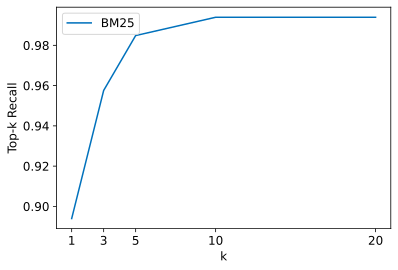

In [113]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"]) # from this outputted graph, we can see no more improvement beyond k=10.

# Dense Passage Retrieval
Now lets look at dense passage retrieval, contrary to the sparse retreival we've been looking at, i.e. BM25 (rule based retriever)

In [114]:
from haystack.nodes import DensePassageRetriever

# DPR relies on bi-encoder architecture, one to encode question vector and passage vector before calculating their dot-product similarity.
        # hence, 2 different embedding model needs to be initialised here: query and passage respectively.
dpr_retriever = DensePassageRetriever(
    document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base", # using encoder already fine-tuned on NQ corpus.
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False) # concatenates document's title normally. However set to false since filter per product, hence this isn't useful.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [115]:
document_store.update_embeddings(retriever=dpr_retriever) # updates embedding for all documents stored in document stores // embeddings are hence generated by the respective bi-encoders

Create embeddings: 100%|██████████| 1616/1616 [00:20<00:00, 78.68 Docs/s]
Updating embeddings: 10000 Docs [00:31, 319.96 Docs/s]


/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

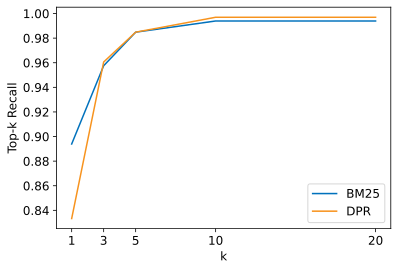

In [116]:
dpr_topk_df = evaluate_retriever(dpr_retriever) # previously defined function, to graph and compare their respective efficiency
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

Evaluating the Reader

In [117]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [118]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [119]:
# The evaluation of a reader can be done by creating a pipeline that consists only of a single node: a reader. In this case, the `pipeline.eval()`
# gets the relevant documents as direct input from the labels.

from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"]) # pipeline is created with only 1 node here. The reader.

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

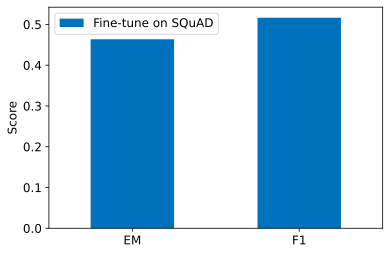

In [120]:
# In the first version no_answer labels weren't taken into account. Because there are quite many of them in the evaluation dataset the numbers differ
# significantly compared to the first version (EM was at ~0.07 and f1 at ~0.25).

def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

Domain Adaptation

In [121]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [122]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [123]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [124]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".",
             use_gpu=True,
             n_epochs=1,
             batch_size=16,
             train_filename=train_filename,
             dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

In [125]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

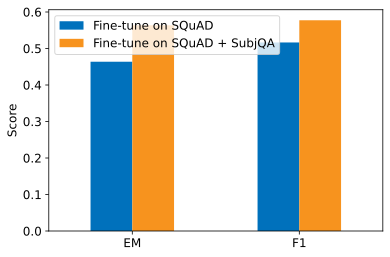

In [126]:
plot_reader_eval(reader_eval)

In [127]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt,
                           progress_bar=False,
                           max_seq_len=max_seq_length,
                           doc_stride=doc_stride,
                           return_no_answer=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [128]:
minilm_reader.train(data_dir=".",
                    use_gpu=True,
                    n_epochs=1,
                    batch_size=16,
                    train_filename=train_filename,
                    dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

In [129]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

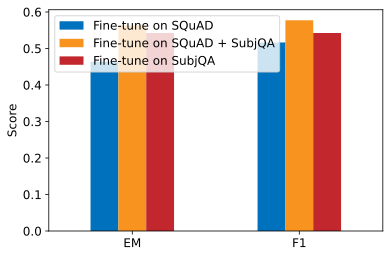

In [130]:
plot_reader_eval(reader_eval)

Evaluating the Whole QA Pipeline

In [131]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

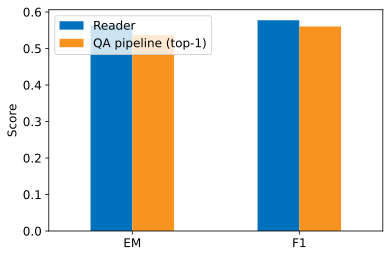

In [132]:
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

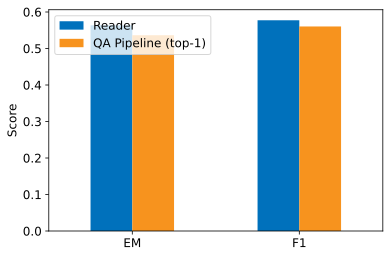

In [133]:
# Or get QA pipeline and Reader metrics in one shot:
# Reader evaluation is run a second time using simulated perfect retriever results
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

# Going Beyond Extractive QA

Sadly I'm unable to get this working :(

Retrieval-Augmented Generation

In [151]:
import os
from getpass import getpass
import logging

# Set up debug logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')

openai_api_key = os.getenv("OPENAI_API_KEY", None) or getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


In [152]:
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser

rag_prompt = PromptTemplate(
    prompt="""Synthesize a comprehensive answer from the following text for the given question.
                             Provide a clear and concise response that summarizes the key points and information presented in the text.
                             Your answer should be in your own words and be no longer than 50 words.
                             \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
    output_parser=AnswerParser(),
)

prompt_node = PromptNode(model_name_or_path="gpt-4-0613	", api_key=openai_api_key, default_prompt_template=rag_prompt)

In [153]:
from haystack.pipelines import Pipeline

pipe = Pipeline()
pipe.add_node(component=dpr_retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])

In [157]:
preds = pipe.run(query=query,
                 params={"retriever": {"top_k":5, "filters":{"item_id": ["B0074BW614"]}}})
print(e)
print(f"Question: {preds['query']} \n")

Exception: Exception while running node 'retriever': ConnectionError(<urllib3.connection.HTTPConnection object at 0x7c65bbafb520>: Failed to establish a new connection: [Errno 111] Connection refused) caused by: NewConnectionError(<urllib3.connection.HTTPConnection object at 0x7c65bbafb520>: Failed to establish a new connection: [Errno 111] Connection refused)
Enable debug logging to see the data that was passed when the pipeline failed.

In [ ]:
preds = pipe.run(query="What is the main drawback?",
                  params={"retriever": {"top_k":5, "filters":{"item_id": ["B0074BW614"]}}})
print(f"Question: {preds['query']} \n")

buffer

In [ ]:

from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)
$

In [ ]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [ ]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k":5,
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [ ]:
generate_answers(query)

In [ ]:
generate_answers("What is the main drawback?")